In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Interpolation Basics

ref: https://www.dsprelated.com/showarticle/1293.php

In [2]:
from scipy.signal import chebwin, freqz, remez, convolve
import numpy as np
from scipy import fftpack


### Original signal, downsampling and spectra 

In [9]:
NFFT = 256
N = 32
fs = 400 # Hz

undersampling_freq = 100 # Hz 

p = chebwin(N,70) # Starting signal (time distance between points is 1/fs)

s = p/sum(p) # normalize signal
u = s[::fs//undersampling_freq] # undersampling input signal from fs to undersampling_freq

## s FFT
s_fft = fftpack.fft(s, n=NFFT)
s_spect = np.abs(s_fft)
s_pow_spect = s_spect**2
L=len(s_pow_spect)
s_freqs = np.array(range(L))*float(fs)/L # Using this instead of fftfreq to show left side of the replica
#s_freqs = fftpack.fftfreq(L) * fs 

## u FFT
u_fft = fftpack.fft(u, n=NFFT)
u_spect = np.abs(u_fft)
u_pow_spect = u_spect**2
L=len(u_pow_spect)
u_freqs = np.array(range(L))*float(undersampling_freq)/L 
#u_freqs = fftpack.fftfreq(L) * undersampling_freq

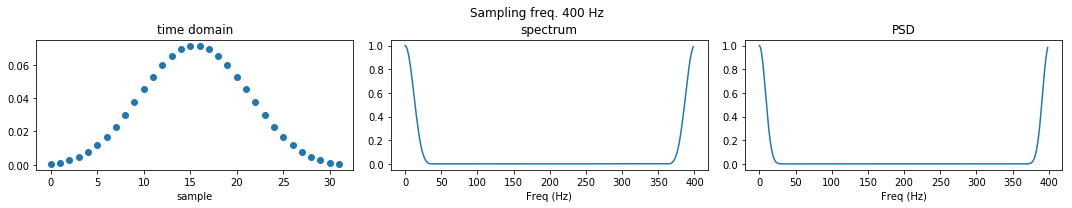

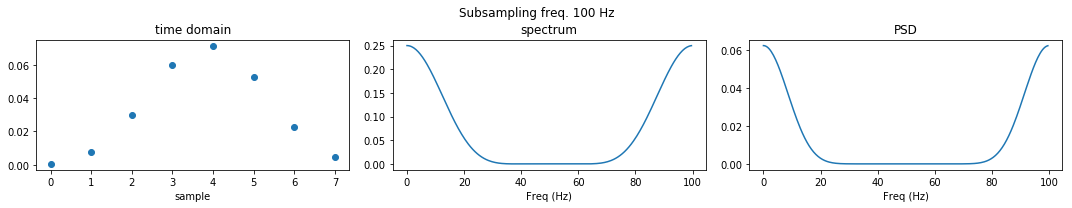

In [10]:
figure(figsize=(15,3))
subplot(1,3,1)
plot(s, 'o')
xlabel('sample')
title("time domain")
subplot(1,3,2)
#stem(s_freqs, s_pow_spect)
plot(s_freqs, s_spect)
xlabel("Freq (Hz)")
title("spectrum")
subplot(1,3,3)
#stem(s_freqs, s_pow_spect)
plot(s_freqs, s_pow_spect)
xlabel("Freq (Hz)")
title("PSD")

suptitle("Sampling freq. 400 Hz")
tight_layout(rect=[0, 0.03, 1, 0.95])

figure(figsize=(15,3))
subplot(1,3,1)
plot(u, 'o')
xlabel('sample')
title("time domain")
subplot(1,3,2)
plot(u_freqs, u_spect)
xlabel("Freq (Hz)")
title("spectrum")
subplot(1,3,3)
plot(u_freqs, u_pow_spect)
xlabel("Freq (Hz)")
title("PSD")

suptitle("Subsampling freq. 100 Hz")
tight_layout(rect=[0, 0.03, 1, 0.95])

Text(0.5, 0.98, 'Aliasing: PSD with different subsampling factors (Sampling freq. starting at 400 Hz)')

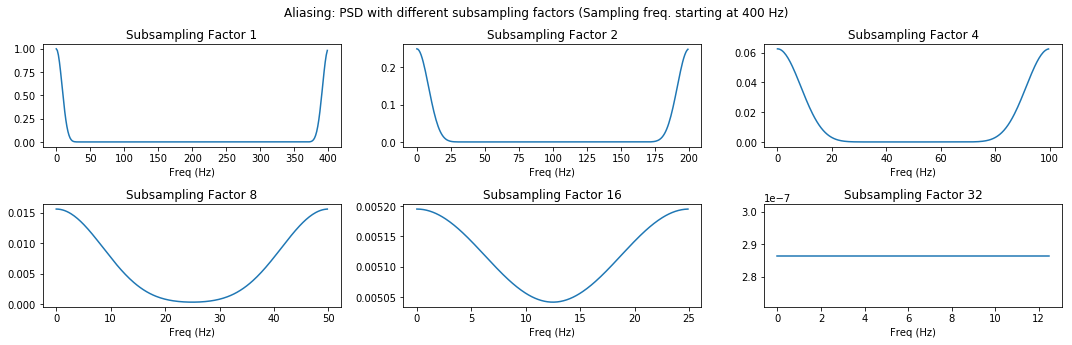

In [11]:
### Aliasing example: This cell is used to show the result of different undersampling frequencies.

figure(figsize=(15,5))
SubSampling=[1, 2, 4, 8, 16, 32]
i=1
for F in SubSampling:
        dataSS=s[::F]
        plt.subplot(2,3,i)
        D=fftpack.fft(dataSS, n=256)
        pD=np.abs(D)**2
        L=len(pD)
        freq=np.array(range(L))*float(fs/F)/L
        plt.plot(freq,pD)
        plt.title("Subsampling Factor %d"%(F))
        plt.xlabel("Freq (Hz)")
        i+=1
tight_layout(rect=[0, 0.03, 1, 0.95])
suptitle("Aliasing: PSD with different subsampling factors (Sampling freq. starting at 400 Hz)")

#### Upsampling

In [16]:
# upsampling
upsampling_factor = 4
upsampling_freq = undersampling_freq * upsampling_factor
x_up = np.zeros(len(u) * upsampling_factor);
x_up[::4] = upsampling_factor*u # upsampling_factor here is used as a gain factor 

# Spectrum of upsampling signal
x_up_fft = fftpack.fft(x_up, n=NFFT)
x_up_spect = np.abs(x_up_fft)
x_up_pow_spect = x_up_spect**2
L=len(x_up_pow_spect)
x_up_freqs = np.array(range(L))*float(upsampling_freq)/L 

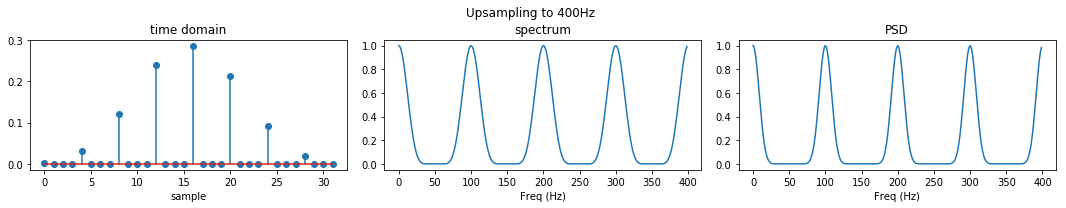

In [17]:
figure(figsize=(15,3))
subplot(1,3,1)
stem(range(len(x_up)), x_up)
xlabel('sample')
title("time domain")
subplot(1,3,2)
plot(x_up_freqs, x_up_spect)
xlabel("Freq (Hz)")
title("spectrum")
subplot(1,3,3)
plot(x_up_freqs, x_up_pow_spect)
xlabel("Freq (Hz)")
title("PSD")

suptitle("Upsampling to 400Hz")
tight_layout(rect=[0, 0.03, 1, 0.95])

#### NB: The spectrum of upsampled signal has replicas between 0 and 400Hz... not good. It needs the interpolation filter
### Interpolation filter

(-9.98046875, 209.58984375, -21.9052456510069, 1.0431069357622336)

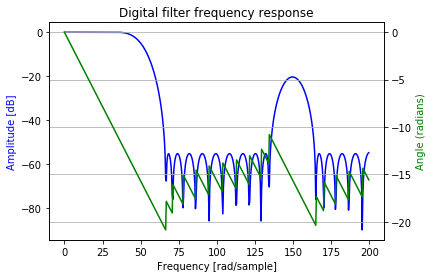

In [19]:
## Interpolation filter using Parks-McClellan algorithm (remez in scipy and firpm in matlab)
numtaps = 41
bands = np.array([0., 36., 66., 135., 166., 199.])
desired = np.array([1., 0., 0.])
up_filter = remez(numtaps, bands, desired, Hz=fs)

# Filter response 
up_filter_f, up_filter_a = freqz(up_filter) # freqz returns, by default, frequency normalized to the range [0, pi) (radians/sample).
up_filter_f = 0.5*fs*up_filter_f/np.pi
up_filter_mag = 20*np.log10(np.abs(up_filter_a))
up_filter_phase = np.unwrap(np.angle(up_filter_a))

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(up_filter_f, up_filter_mag, 'b', label='Magnitude (db)')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
ax2.plot(up_filter_f, up_filter_phase, 'g', label="Phase")
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')



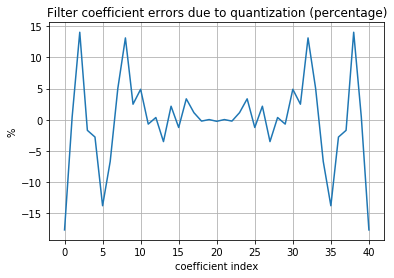

In [20]:
## Quantization of filter coefficients

fixed_point_n = 10
up_filter_fixed_point= np.round(up_filter*2**(fixed_point_n-1))/2**(fixed_point_n-1)
#plot(up_filter)
plot(100 * (up_filter - up_filter_fixed_point) / up_filter)
title("Filter coefficient errors due to quantization (percentage)")
ylabel('%')
xlabel('coefficient index')
grid()

### Interpolation: Convolving upsampled signal with interpolation filter

In [21]:
# Convolution
x_interp = convolve(x_up, up_filter_fixed_point)

# Spectrum of interpolated signal
x_interp_fft = fftpack.fft(x_interp, n=NFFT)
x_interp_spect = np.abs(x_interp_fft)
x_interp_pow_spect = x_interp_spect**2
L=len(x_interp_pow_spect)
x_interp_freqs = np.array(range(L))*float(upsampling_freq)/L 

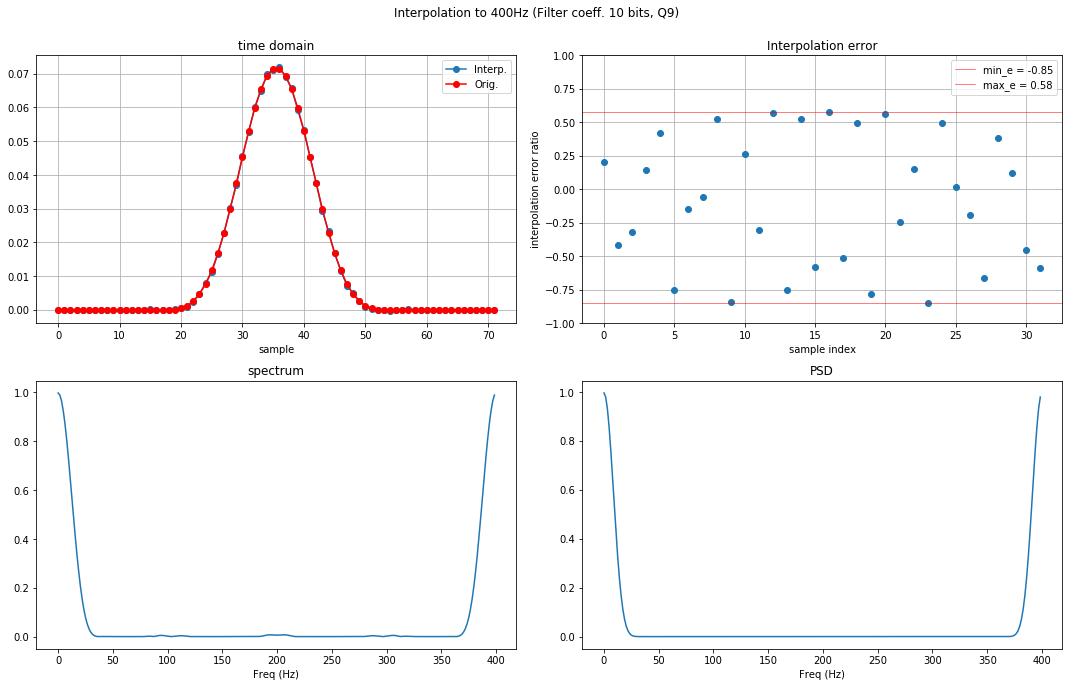

In [22]:
figure(figsize=(15,10))
subplot(2,2,1)
plot(range(len(x_interp)), x_interp, 'o-', label='Interp.')
plot(range(len(x_interp)), np.hstack((np.zeros(20),s,np.zeros(20))), 'o-', c='r', label='Orig.')
xlabel('sample')
title("time domain")
legend()
grid()

subplot(2,2,2)
interp_error= 100*(x_interp[20:52] - s)/max(s) # Slicing due to the 0 padding convolution
plot(interp_error, 'o')
ylim(-1.0, 1.0)
xlabel("sample index")
ylabel("interpolation error ratio")
title("Interpolation error")
grid()
min_e = min(interp_error)
axhline(min_e, label='min_e = %.2f' % min_e, lw = .5, c='r')
max_e = max(interp_error)
axhline(max_e, label='max_e = %.2f' % max_e, lw = .5, c='r')
legend()

subplot(2,2,3)
plot(x_interp_freqs, x_interp_spect)
xlabel("Freq (Hz)")
title("spectrum")

subplot(2,2,4)
plot(x_interp_freqs, x_interp_pow_spect)
xlabel("Freq (Hz)")
title("PSD")

suptitle("Interpolation to 400Hz (Filter coeff. %d bits, Q%d)" % (fixed_point_n, fixed_point_n-1))
tight_layout(rect=[0, 0.03, 1, 0.95])